<a href="https://colab.research.google.com/github/RatchanonPa/bsc_dpdm24/blob/main/Thal_Group_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import f1_score, classification_report
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pd.set_option("display.max_columns", None)

# Load data


In [ ]:
train = pd.read_csv('/content/drive/MyDrive/bsc_dpdm24_data/train_set.csv')
train

,id number,Xn,Hb(Gm%),Hct(%),MCV(fl),A2 (2-3%),HbF (2%),HbA (95-97%),RBC,MCH,MCHC,MCV-RBC-3*HGB,MCV-RBC-5*HGB,|80-MCV|,|27-MCH|,|80-MCV|*|27-MCH|,Thal_Group
0,67d169,25.0,11.1,34.0,78.0,3.2,0.0,55.9,4.358974,25.464706,32.647059,40.341026,18.141026,2.0,1.535294,3.070588,Abnormal_variants
1,67l168,32.0,13.9,42.0,86.0,3.7,0.3,54.8,5.197674,28.859060,33.557047,35.802326,5.802326,6.0,1.859060,11.154362,Abnormal_variants
2,67i267,43.0,10.1,31.0,78.0,2.6,0.3,56.2,3.974359,25.412903,32.580645,43.725641,23.525641,2.0,1.587097,3.174194,Abnormal_variants
3,67e248,33.0,12.9,38.0,76.0,3.0,0.2,61.2,5.000000,25.800000,33.947368,32.300000,6.500000,4.0,1.200000,4.800000,Abnormal_variants
4,67h277,23.0,12.9,40.0,78.0,3.1,0.0,55.6,5.128205,25.155000,32.250000,34.171795,8.371795,2.0,1.845000,3.690000,Abnormal_variants
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4317,66z431,63.0,10.1,31.0,83.0,2.8,1.8,84.2,3.734940,27.041935,32.580645,48.965060,28.765060,3.0,0.041935,0.125806,Normal
4318,66z436,19.0,11.1,34.0,79.0,2.6,0.6,78.0,4.303797,25.791176,32.647059,41.396203,19.196203,1.0,1.208824,1.208824,Normal
4319,66z439,80.0,10.9,33.9,79.0,3.0,0.2,87.2,4.291139,25.401180,32.153392,42.008861,20.208861,1.0,1.598820,1.598820,Normal
4320,66z445,27.0,13.2,41.4,87.0,2.9,0.3,87.6,4.758621,27.739130,31.884058,42.641379,16.241379,7.0,0.739130,5.173913,Normal


In [ ]:
test = pd.read_csv('/content/drive/MyDrive/bsc_dpdm24_data/X_test.csv')
test

,id number,Xn,Hb(Gm%),Hct(%),MCV(fl),A2 (2-3%),HbF (2%),HbA (95-97%),RBC,MCH,MCHC,MCV-RBC-3*HGB,MCV-RBC-5*HGB,|80-MCV|,|27-MCH|,|80-MCV|*|27-MCH|
0,66z133,38.0,12.4,37.00,78.0,2.7,1.3,75.4,4.743590,26.140541,33.513514,36.056410,11.256410,2.0,0.859459,1.718919
1,66z297,28.0,12.8,39.40,82.0,2.7,0.0,97.3,4.804878,26.639594,32.487310,38.795122,13.195122,2.0,0.360406,0.720812
2,66u491,78.0,10.9,33.90,79.0,3.1,0.0,96.9,4.291139,25.401180,32.153392,42.008861,20.208861,1.0,1.598820,1.598820
3,66x072,65.0,10.9,33.90,79.0,3.0,0.2,87.9,4.291139,25.401180,32.153392,42.008861,20.208861,1.0,1.598820,1.598820
4,67m031,17.0,11.5,36.00,78.0,2.8,0.8,79.6,4.615385,24.916667,31.944444,38.884615,15.884615,2.0,2.083333,4.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1992,67j317,NaN,8.4,26.00,59.0,2.6,0.7,0.3,4.406780,19.061538,32.307692,29.393220,12.593220,21.0,7.938462,166.707692
1993,66a385,NaN,10.1,31.00,78.0,3.3,0.0,55.0,3.974359,25.412903,32.580645,43.725641,23.525641,2.0,1.587097,3.174194
1994,67g355,53.0,10.4,34.00,77.0,3.0,0.2,49.6,4.415584,23.552941,30.588235,41.384416,20.584416,3.0,3.447059,10.341176
1995,66s121,54.0,10.1,31.00,78.0,2.4,0.3,42.0,3.974359,25.412903,32.580645,43.725641,23.525641,2.0,1.587097,3.174194


In [ ]:
print(train.shape)
print(train.columns)
train.duplicated().sum()

(4322, 17)
Index(['id number', 'Xn', 'Hb(Gm%)', 'Hct(%)', 'MCV(fl)', 'A2 (2-3%)',
       'HbF (2%)', 'HbA (95-97%)', 'RBC', 'MCH', 'MCHC', 'MCV-RBC-3*HGB',
       'MCV-RBC-5*HGB', '|80-MCV|', '|27-MCH|', '|80-MCV|*|27-MCH|',
       'Thal_Group'],
      dtype='object')


0

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4322 entries, 0 to 4321
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id number          4322 non-null   object 
 1   Xn                 3887 non-null   float64
 2   Hb(Gm%)            4315 non-null   float64
 3   Hct(%)             4315 non-null   float64
 4   MCV(fl)            4315 non-null   float64
 5   A2 (2-3%)          4189 non-null   float64
 6   HbF (2%)           4206 non-null   float64
 7   HbA (95-97%)       4206 non-null   float64
 8   RBC                4315 non-null   float64
 9   MCH                4315 non-null   float64
 10  MCHC               4315 non-null   float64
 11  MCV-RBC-3*HGB      4315 non-null   float64
 12  MCV-RBC-5*HGB      4315 non-null   float64
 13  |80-MCV|           4315 non-null   float64
 14  |27-MCH|           4315 non-null   float64
 15  |80-MCV|*|27-MCH|  4315 non-null   float64
 16  Thal_Group         4322 

In [ ]:
train.describe()

,Xn,Hb(Gm%),Hct(%),MCV(fl),A2 (2-3%),HbF (2%),HbA (95-97%),RBC,MCH,MCHC,MCV-RBC-3*HGB,MCV-RBC-5*HGB,|80-MCV|,|27-MCH|,|80-MCV|*|27-MCH|
count,3887.000000,4315.000000,4315.000000,4315.000000,4189.000000,4206.000000,4206.000000,4315.000000,4315.000000,4315.000000,4315.000000,4315.000000,4315.000000,4315.000000,4315.000000
mean,40.510059,10.370717,32.448678,70.919177,11.530902,1.497967,80.268503,4.635384,22.654757,31.857088,34.924984,14.108856,10.002491,4.556300,72.895320
std,24.383982,1.997339,5.512625,9.471956,18.457527,5.985359,22.044018,0.789678,3.652130,1.543573,9.254880,10.762377,8.631753,3.427993,91.344636
min,0.000000,1.600000,3.700000,43.000000,0.000000,0.000000,0.000000,0.395062,8.703704,17.407407,4.967967,-20.333070,0.000000,0.000000,0.000000
25%,24.000000,9.400000,30.000000,64.000000,2.400000,0.000000,74.200000,4.291139,19.732143,30.947042,28.426374,7.420635,2.000000,1.598820,1.598820
50%,36.000000,10.700000,33.000000,73.000000,2.900000,0.400000,86.500000,4.605263,23.594248,32.153392,35.306897,12.894737,8.000000,3.654545,27.000000
75%,62.000000,11.350000,35.000000,79.000000,16.500000,1.100000,96.000000,5.079365,25.401180,32.727273,42.008861,20.208861,17.000000,7.267857,118.400000
max,97.000000,19.600000,53.100000,109.000000,100.000000,99.200000,118.900000,7.742601,36.364999,36.969697,83.949485,76.149485,43.000000,18.296296,548.888889


# Preprocessing

In [ ]:
train.isnull().sum()

,0
id number,0
Xn,435
Hb(Gm%),7
Hct(%),7
MCV(fl),7
A2 (2-3%),133
HbF (2%),116
HbA (95-97%),116
RBC,7
MCH,7


In [ ]:
set(train['Thal_Group'])

{'Abnormal_variants',
 'Alpha_thal_related',
 'Beta_thal_related',
 'Complex_genotypes',
 'HbE_related',
 'Normal'}

In [ ]:
# เติมค่าขาดหายด้วย median
for col in train.select_dtypes(include=['float64', 'int64']):
    train[col].fillna(train[col].median(), inplace=True)
for col in test.select_dtypes(include=['float64', 'int64']):
    test[col].fillna(test[col].median(), inplace=True)

print(train.isnull().sum())
print(test.isnull().sum())

id number            0
Xn                   0
Hb(Gm%)              0
Hct(%)               0
MCV(fl)              0
A2 (2-3%)            0
HbF (2%)             0
HbA (95-97%)         0
RBC                  0
MCH                  0
MCHC                 0
MCV-RBC-3*HGB        0
MCV-RBC-5*HGB        0
|80-MCV|             0
|27-MCH|             0
|80-MCV|*|27-MCH|    0
Thal_Group           0
dtype: int64
id number            0
Xn                   0
Hb(Gm%)              0
Hct(%)               0
MCV(fl)              0
A2 (2-3%)            0
HbF (2%)             0
HbA (95-97%)         0
RBC                  0
MCH                  0
MCHC                 0
MCV-RBC-3*HGB        0
MCV-RBC-5*HGB        0
|80-MCV|             0
|27-MCH|             0
|80-MCV|*|27-MCH|    0
dtype: int64


<ipython-input-180-81b3a3dfa18d>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train[col].fillna(train[col].median(), inplace=True)
<ipython-input-180-81b3a3dfa18d>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', tr

In [ ]:
# แปลง Thal_Group เป็นตัวเลข
thal_mapping = {'Abnormal_variants': 5, 'Alpha_thal_related': 4,
                'Beta_thal_related': 3, 'Complex_genotypes': 2,
                'HbE_related': 1, 'Normal': 0}
train['Thal_Group'] = train['Thal_Group'].map(thal_mapping)
train

,id number,Xn,Hb(Gm%),Hct(%),MCV(fl),A2 (2-3%),HbF (2%),HbA (95-97%),RBC,MCH,MCHC,MCV-RBC-3*HGB,MCV-RBC-5*HGB,|80-MCV|,|27-MCH|,|80-MCV|*|27-MCH|,Thal_Group
0,67d169,25.0,11.1,34.0,78.0,3.2,0.0,55.9,4.358974,25.464706,32.647059,40.341026,18.141026,2.0,1.535294,3.070588,5
1,67l168,32.0,13.9,42.0,86.0,3.7,0.3,54.8,5.197674,28.859060,33.557047,35.802326,5.802326,6.0,1.859060,11.154362,5
2,67i267,43.0,10.1,31.0,78.0,2.6,0.3,56.2,3.974359,25.412903,32.580645,43.725641,23.525641,2.0,1.587097,3.174194,5
3,67e248,33.0,12.9,38.0,76.0,3.0,0.2,61.2,5.000000,25.800000,33.947368,32.300000,6.500000,4.0,1.200000,4.800000,5
4,67h277,23.0,12.9,40.0,78.0,3.1,0.0,55.6,5.128205,25.155000,32.250000,34.171795,8.371795,2.0,1.845000,3.690000,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4317,66z431,63.0,10.1,31.0,83.0,2.8,1.8,84.2,3.734940,27.041935,32.580645,48.965060,28.765060,3.0,0.041935,0.125806,0
4318,66z436,19.0,11.1,34.0,79.0,2.6,0.6,78.0,4.303797,25.791176,32.647059,41.396203,19.196203,1.0,1.208824,1.208824,0
4319,66z439,80.0,10.9,33.9,79.0,3.0,0.2,87.2,4.291139,25.401180,32.153392,42.008861,20.208861,1.0,1.598820,1.598820,0
4320,66z445,27.0,13.2,41.4,87.0,2.9,0.3,87.6,4.758621,27.739130,31.884058,42.641379,16.241379,7.0,0.739130,5.173913,0


# Exploratory

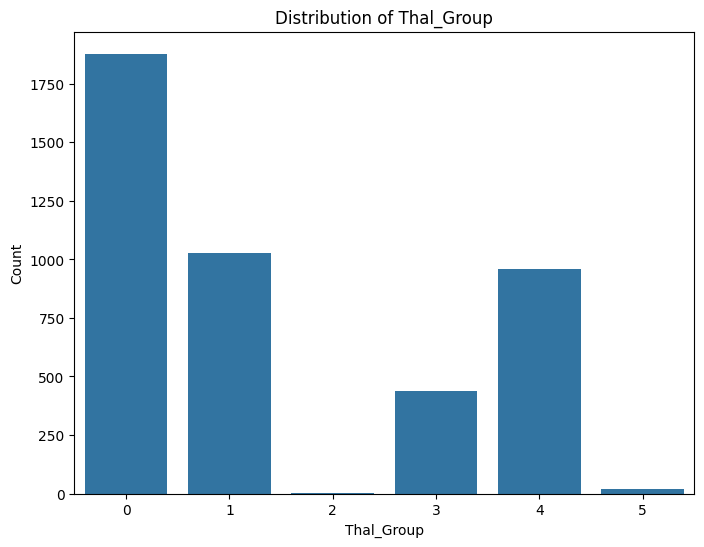

In [ ]:
# prompt: visualize train['Thal_Group']

import matplotlib.pyplot as plt
import seaborn as sns
# Visualize Thal_Group
plt.figure(figsize=(8, 6))
sns.countplot(x='Thal_Group', data=train)
plt.title('Distribution of Thal_Group')
plt.xlabel('Thal_Group')
plt.ylabel('Count')
plt.show()


In [ ]:
# prompt: group by train['Thal_Group']

# Group data by 'Thal_Group'
grouped_thal = train.groupby('Thal_Group')

# Print some descriptive statistics for each group
grouped_thal.count()


,id number,Xn,Hb(Gm%),Hct(%),MCV(fl),A2 (2-3%),HbF (2%),HbA (95-97%),RBC,MCH,MCHC,MCV-RBC-3*HGB,MCV-RBC-5*HGB,|80-MCV|,|27-MCH|,|80-MCV|*|27-MCH|
Thal_Group,,,,,,,,,,,,,,,,
0,1878,1878,1878,1878,1878,1878,1878,1878,1878,1878,1878,1878,1878,1878,1878,1878
1,1025,1025,1025,1025,1025,1025,1025,1025,1025,1025,1025,1025,1025,1025,1025,1025
2,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
3,439,439,439,439,439,439,439,439,439,439,439,439,439,439,439,439
4,959,959,959,959,959,959,959,959,959,959,959,959,959,959,959,959
5,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18


In [ ]:
grouped_thal.describe()

Xn                                                      \
             count       mean        std  min    25%   50%   75%   max   
Thal_Group                                                               
0           1878.0  40.914803  22.997468  0.0  27.00  36.0  60.0  97.0   
1           1025.0  35.530341  19.217969  0.0  24.00  33.0  41.0  90.0   
2              3.0  32.666667  34.645827  0.0  14.50  29.0  49.0  69.0   
3            439.0  45.337130  27.265401  0.0  26.00  48.0  69.0  97.0   
4            959.0  40.813347  24.510481  0.0  24.00  36.0  62.0  92.0   
5             18.0  40.277778  22.624312  3.0  31.25  37.5  43.0  88.0   

           Hb(Gm%)                                                       \
             count       mean       std  min    25%   50%     75%   max   
Thal_Group                                                                
0           1878.0  10.402556  2.081638  3.1   9.30  10.9  10.900  19.6   
1           1025.0  11.332098  1.971726  4.0  10.40  11.7  12.300  16.1   
2              3.0   9.933333  2.309401  8.6   8.60   8.6  10.600  12.6   
3            439.0   9.793041  1.189510  1.6   9.55  10.1  10.100  13.3   
4            959.0   9.535245  1.661219  3.8   8.40   9.8  10.200  13.5   
5             18.0  11.105556  1.659366  8.4  10.10  10.6  12.575  13.9   

            Hct(%)                                                      \
             count       mean       std   min   25%    50%   75%   max   
Thal_Group                                                               
0           1878.0  32.443184  5.747411   3.7  30.0  33.90  33.9  53.1   
1           1025.0  34.425566  5.660617  14.3  31.0  35.00  37.0  49.1   
2              3.0  31.666667  6.350853  28.0  28.0  28.00  33.5  39.0   
3            439.0  31.053075  3.555947   5.0  30.0  32.00  32.0  42.3   
4            959.0  30.969281  4.929035  13.0  28.0  31.80  33.0  42.8   
5             18.0  33.650000  4.879398  26.0  31.0  31.85  37.0  42.0   

           MCV(fl)                                                       \
             count       mean       std   min   25%   50%    75%    max   
Thal_Group                                                                
0           1878.0  75.824814  8.563510  43.0  74.0  79.0  79.00  109.0   
1           1025.0  72.132195  8.771463  45.0  69.0  76.0  77.00   88.0   
2              3.0  67.000000  1.732051  66.0  66.0  66.0  67.50   69.0   
3            439.0  63.663440  4.043241  46.0  63.0  63.0  63.50   81.0   
4            959.0  63.201512  6.033602  47.0  60.0  64.0  66.00   88.0   
5             18.0  79.625000  3.869422  71.0  78.0  78.0  82.75   86.0   

           A2 (2-3%)                                                          \
               count       mean        std   min     25%   50%    75%    max   
Thal_Group                                                                     
0             1878.0   2.619302   0.548824   0.5   2.300   2.7   2.90   10.7   
1             1025.0  34.458537  22.045642   2.9  24.500  27.6  29.90  100.0   
2                3.0  21.166667   0.404145  20.8  20.950  21.1  21.35   21.6   
3              439.0   5.582916   0.759328   2.1   5.300   5.6   6.00    8.3   
4              959.0   6.128363  14.634608   0.0   1.800   2.4   2.80   82.0   
5               18.0   3.227778   0.425379   2.3   2.925   3.2   3.65    3.9   

           HbF (2%)                                                    \
              count      mean        std  min   25%  50%   75%    max   
Thal_Group                                                              
0            1878.0  0.448669   1.149152  0.0  0.00  0.3  0.50  36.80   
1            1025.0  1.435951   1.893838  0.0  0.20  0.9  1.80  11.35   
2               3.0  4.666667   7.653975  0.0  0.25  0.5  7.00  13.50   
3             439.0  3.181036  11.236431  0.0  0.40  0.9  2.15  99.20   
4             959.0  2.730474   9.384989  0.0  0.00  0.4  0.80  72.80   
5              18.0  0.18

Xn                   0.031585
Hb(Gm%)             -0.206005
Hct(%)              -0.137745
MCV(fl)             -0.553068
A2 (2-3%)           -0.031507
HbF (2%)             0.166058
HbA (95-97%)        -0.047681
RBC                  0.309390
MCH                 -0.554896
MCHC                -0.308255
MCV-RBC-3*HGB       -0.460495
MCV-RBC-5*HGB       -0.320208
|80-MCV|             0.532482
|27-MCH|             0.548196
|80-MCV|*|27-MCH|    0.433194
Thal_Group           1.000000
Name: Thal_Group, dtype: float64


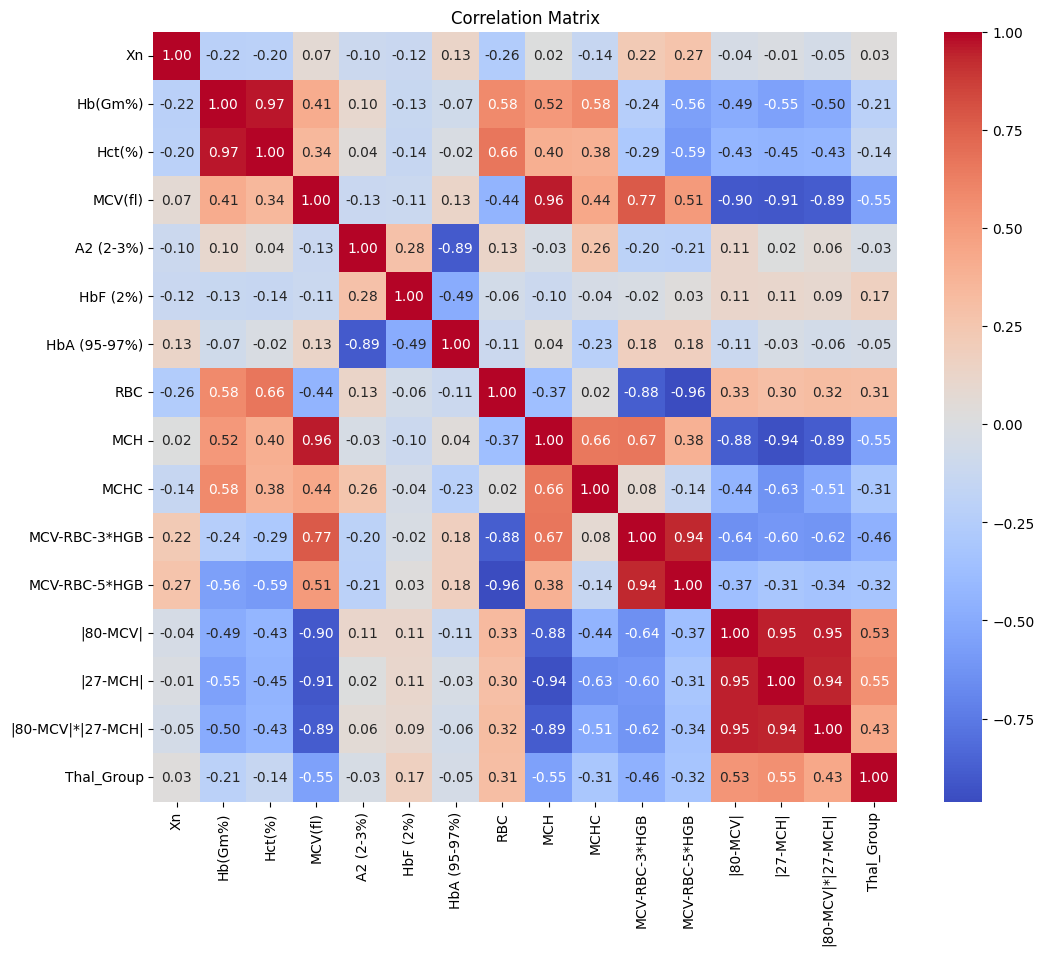

In [ ]:
# Now calculate the correlation
correlation_thal = train.drop('id number', axis=1).corr()['Thal_Group']

# Display the correlation
print(correlation_thal)

# Visualize the correlation using a heatmap (optional)
plt.figure(figsize=(12, 10))
sns.heatmap(train.drop('id number', axis=1).corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

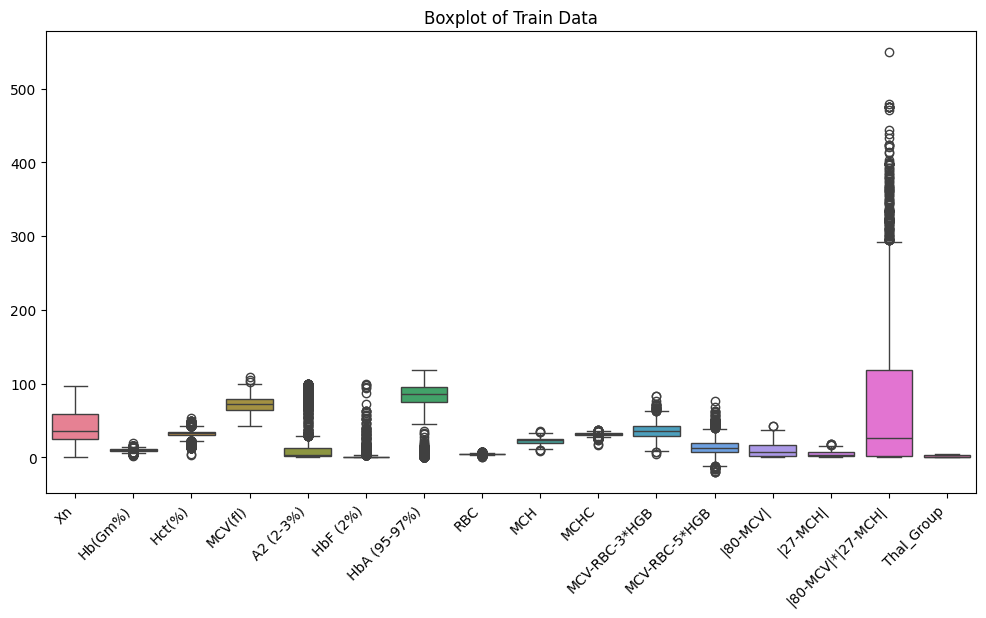

In [ ]:
# prompt: plot boxplot of train

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
sns.boxplot(data=train)
plt.xticks(rotation=45, ha='right')
plt.title('Boxplot of Train Data')
plt.show()

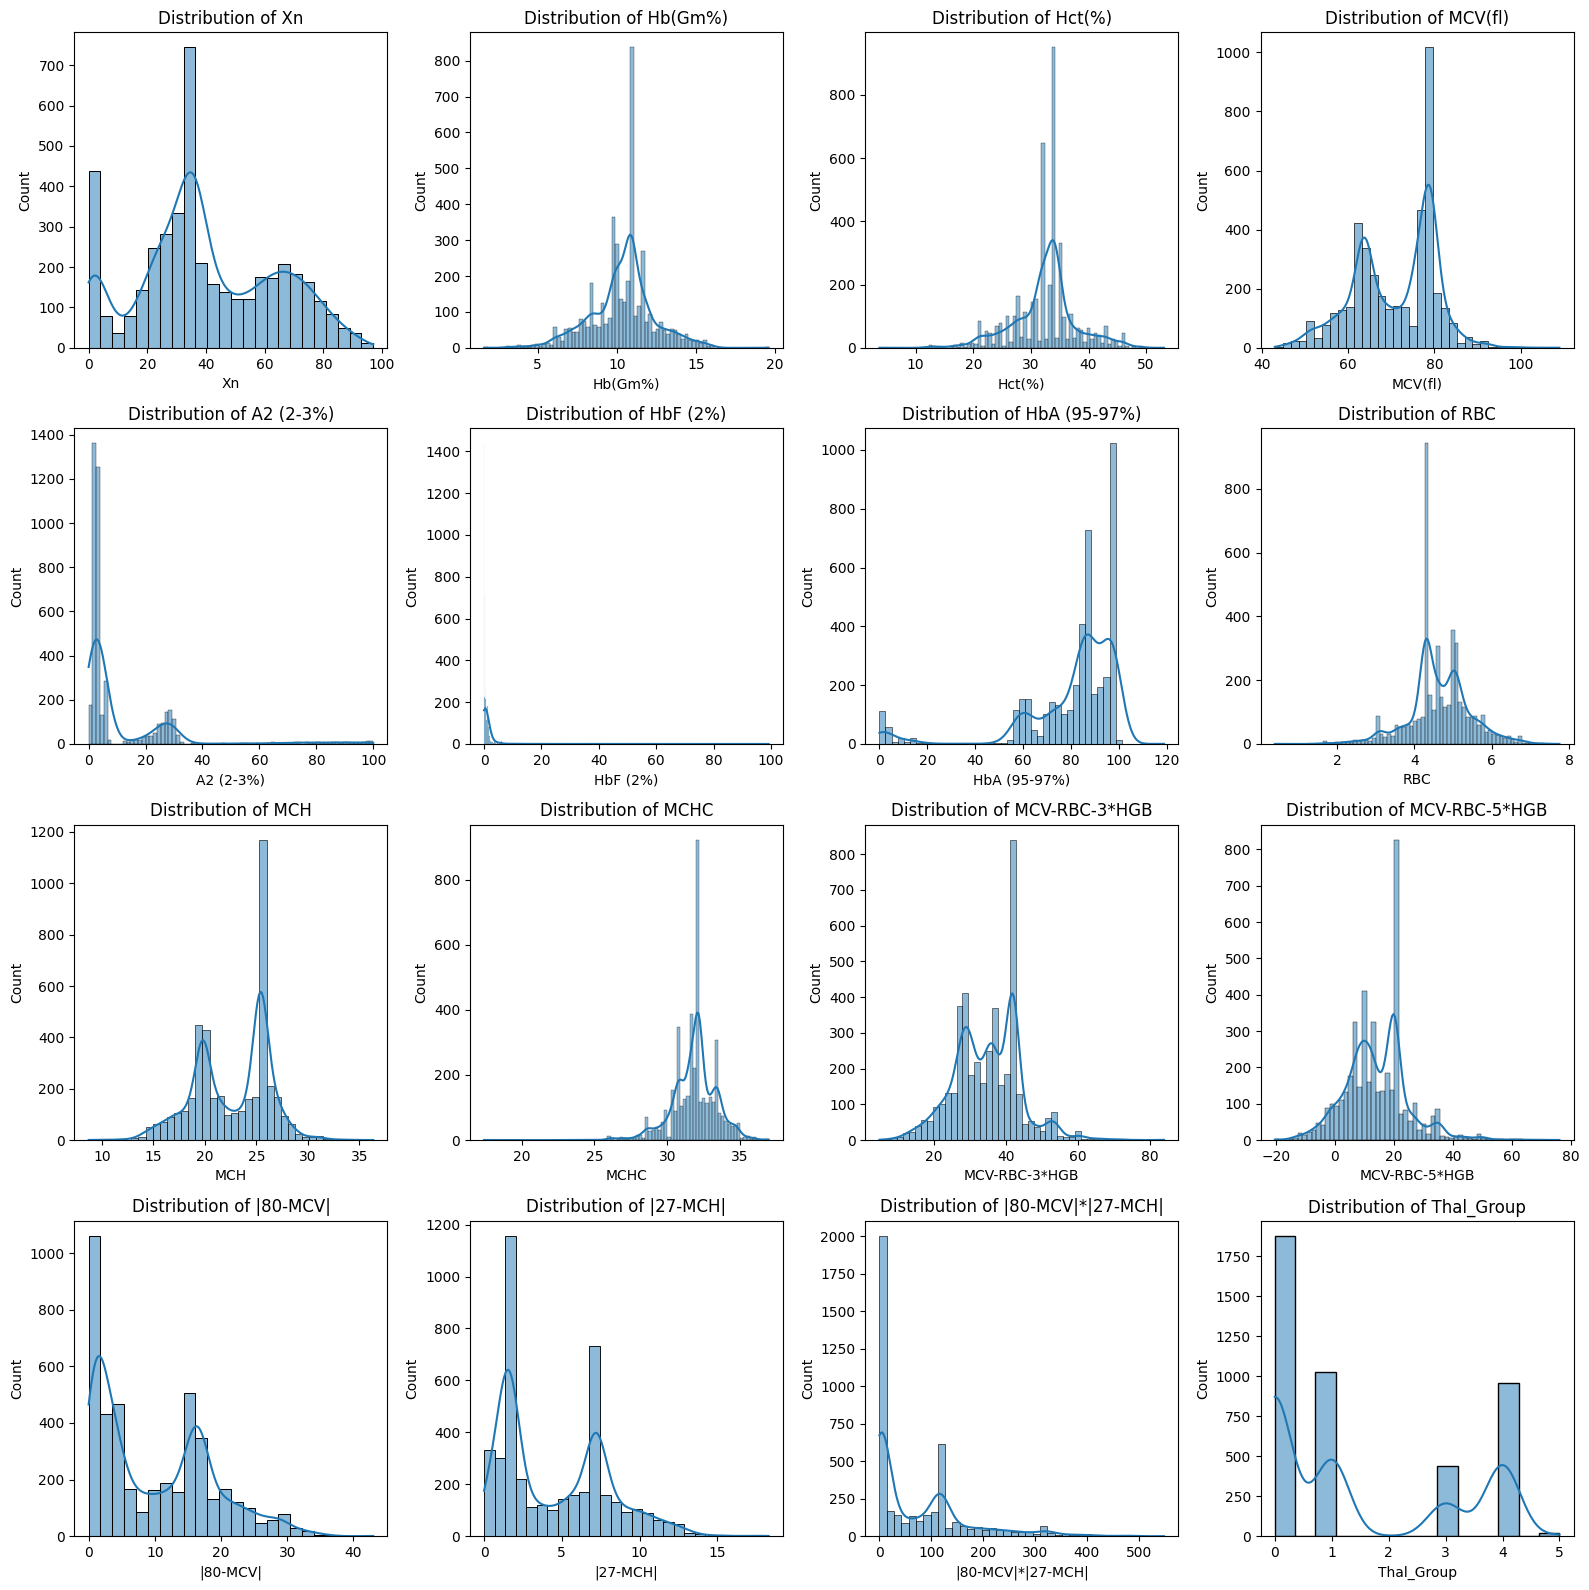

In [ ]:
# Drop 'id number' column
train = train.drop('id number', axis=1)

# Calculate the number of rows and columns for the subplot grid
num_cols = train.shape[1]
num_rows = int(np.ceil(num_cols / 4))

# Create the subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=4, figsize=(16, 4 * num_rows))
axes = axes.ravel()  # Flatten the axes array for easier iteration

# Plot the distributions for each column
for i, column in enumerate(train.columns):
    sns.histplot(train[column], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {column}')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')  # Turn off the axes for unused plots

plt.tight_layout()
plt.show()

# Model

In [ ]:
# แยก Features และ Target จาก Train Set
X_train_full = train.drop(columns=['Thal_Group'])
y_train_full = train['Thal_Group']
test = test.drop('id number', axis=1)

In [ ]:
# 2️⃣ ทำ Scaling ข้อมูล
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_full)  # Fit + Transform เฉพาะ Train
X_test_scaled = scaler.transform(test)  # Transform ชุด Test

In [ ]:
# กำหนด sampling_strategy ให้ resample ข้อมูลตามที่ต้องการ
sampling_strategy = {2: 25, 5: 50}

# ปรับพารามิเตอร์ของ SMOTE
smote = SMOTE(random_state=42, sampling_strategy=sampling_strategy, k_neighbors=2)

# ทำ resample ข้อมูล
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train_full)

# ตรวจสอบจำนวนตัวอย่างในแต่ละคลาส
print(pd.Series(y_train_full).value_counts())  # ก่อน SMOTE
print(pd.Series(y_train_resampled).value_counts())  # หลัง SMOTE

Thal_Group
0    1878
1    1025
4     959
3     439
5      18
2       3
Name: count, dtype: int64
Thal_Group
0    1878
1    1025
4     959
3     439
5      50
2      25
Name: count, dtype: int64


## Decision Tree

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Define Stratified K-fold cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [ ]:
from sklearn.tree import DecisionTreeClassifier # Import DecisionTreeClassifier

# Define Decision Tree classifier
dt_classifier = DecisionTreeClassifier(class_weight='balanced', random_state=42)  # default

# Train & evaluate (cross-validation)
dt_cv_scores = cross_val_score(dt_classifier, X_train_resampled, y_train_resampled, cv=skf, scoring='f1_macro')

# Print the cross-validation scores
print(f"Cross-validation scores: {dt_cv_scores}")
print(f"Mean f1_macro: {dt_cv_scores.mean()}")
print("Standard deviation of cross-validation scores:", dt_cv_scores.std())

Cross-validation scores: [0.83378513 0.94784485 0.95102776 0.93914075 0.92942261 0.93776861
 0.86759495 0.89730386 0.94264777 0.94149804]
Mean f1_macro: 0.9188034325544642
Standard deviation of cross-validation scores: 0.0376352395253726


## Short Decision Tree

In [ ]:
# Define Short Decision Tree classifier
sdt_classifier = DecisionTreeClassifier(max_depth=5, class_weight='balanced', random_state=42)  # default

# Train & evaluate (cross-validation)
sdt_cv_scores = cross_val_score(sdt_classifier, X_train_resampled, y_train_resampled, cv=skf, scoring='f1_macro')

# Print the cross-validation scores
print(f"Cross-validation scores: {sdt_cv_scores}")
print(f"Mean f1_macro: {sdt_cv_scores.mean()}")
print("Standard deviation of cross-validation scores:", sdt_cv_scores.std())

Cross-validation scores: [0.81091947 0.92985059 0.93728452 0.88950963 0.89684333 0.90288727
 0.85519627 0.87996221 0.93237514 0.93357802]
Mean f1_macro: 0.8968406444083878
Standard deviation of cross-validation scores: 0.03850920350756219


## Support Vector Machine

In [ ]:
# Define Support Vector Machine classifier
svm_classifier = SVC(class_weight='balanced', probability=True)

# Train & evaluate (cross-validation)
svm_cv_scores = cross_val_score(svm_classifier, X_train_resampled, y_train_resampled, cv=skf, scoring='f1_macro')

# Print the cross-validation scores
print(f"Cross-validation scores: {svm_cv_scores}")
print(f"Mean f1_macro: {svm_cv_scores.mean()}")
print("Standard deviation of cross-validation scores:", svm_cv_scores.std())

Cross-validation scores: [0.77583229 0.82288792 0.7884189  0.80245107 0.82426074 0.77749686
 0.78232966 0.84117827 0.78226871 0.78564915]
Mean f1_macro: 0.7982773580947251
Standard deviation of cross-validation scores: 0.02200363768064552


## Random Forest

In [ ]:
# Define classifiers
rf_classifier = RandomForestClassifier(class_weight='balanced', random_state=42)

# Train & evaluate RandomForest (cross-validation)
rf_cv_scores = cross_val_score(rf_classifier, X_train_resampled, y_train_resampled, cv=skf, scoring='f1_macro')
print(f"RandomForest Cross-validation scores: {rf_cv_scores}")
print(f"Mean f1_macro (RandomForest): {rf_cv_scores.mean()}")
print(f"Standard deviation: {rf_cv_scores.std()}")

RandomForest Cross-validation scores: [0.85858752 0.9591506  0.96318487 0.95085228 0.9578952  0.94580139
 0.93585508 0.91942307 0.95864958 0.94543978]
Mean f1_macro (RandomForest): 0.9394839366861254
Standard deviation: 0.02969725145782076


## XGBoost

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# คำนวณ class weight สำหรับ y_train
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_resampled), y=y_train_resampled)

# แสดงผล class weights
print(f"Class weights: {dict(zip(np.unique(y_train_resampled), class_weights))}")

# นำค่า class weight มาใช้ใน XGBClassifier
xgb_classifier = XGBClassifier(
    use_label_encoder=False,
    eval_metric="mlogloss",  # ใช้ 'mlogloss' สำหรับ multi-class
    tree_method="hist",
    objective="multi:softmax",  # ตั้งค่าให้เหมาะกับ multi-class
    scale_pos_weight=class_weights
)

# คำนวณ cross-validation score โดยใช้ F1 Macro
xgb_cv_scores = cross_val_score(xgb_classifier, X_train_resampled, y_train_resampled, cv=skf, scoring='f1_macro')

# แสดงผลลัพธ์
print(f"XGBoost Cross-validation scores: {xgb_cv_scores}")
print(f"Mean f1_macro (XGBoost): {xgb_cv_scores.mean()}")
print(f"Standard deviation: {xgb_cv_scores.std()}")


Class weights: {0: 0.3883564075257366, 1: 0.7115447154471545, 2: 29.173333333333332, 3: 1.6613515565679575, 4: 0.7605144247480013, 5: 14.586666666666666}
XGBoost Cross-validation scores: [0.87621669 0.96539381 0.96937327 0.95086045 0.96567953 0.93094918
 0.9319785  0.92378356 0.96158632 0.91680897]
Mean f1_macro (XGBoost): 0.9392630276951671
Standard deviation: 0.02785844430605334


# Hyperparameter Tuning

In [ ]:
from sklearn.metrics import make_scorer, f1_score

In [ ]:
# กำหนดโมเดล RandomForestClassifier
rf_classifier = RandomForestClassifier(class_weight='balanced', random_state=42)

In [ ]:
# กำหนดพารามิเตอร์สำหรับ tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

In [ ]:
# ใช้ GridSearchCV เพื่อหาค่าพารามิเตอร์ที่ดีที่สุด
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid,
                           cv=skf, scoring='f1_macro', n_jobs=-1)

In [ ]:
# ฝึกโมเดลด้วย GridSearchCV
grid_search.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='f1_macro')

In [ ]:
# แสดงผลลัพธ์ที่ดีที่สุด
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best F1 Macro Score: {grid_search.best_score_}")

Best Parameters: {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best F1 Macro Score: 0.9480747805469638


In [ ]:
# สร้าง RandomForestClassifier ใหม่ด้วยพารามิเตอร์ที่ดีที่สุด
best_model = RandomForestClassifier(
    bootstrap=False,
    max_depth=20,
    min_samples_leaf=1,
    min_samples_split=5,
    n_estimators=100,
    class_weight='balanced',  # ใช้ class_weight='balanced' เพื่อแก้ปัญหาคลาสไม่สมดุล
    random_state=42
)

# ฝึกโมเดลใหม่ด้วยข้อมูลทั้งหมด (train_resampled)
final_model = best_model.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(bootstrap=False, class_weight='balanced', max_depth=20,
                       min_samples_split=5, random_state=42)

# Prediction & Submission

In [ ]:
# ทำนายผลลัพธ์
test_pred = final_model.predict(X_test_scaled)
print(len(test_pred))
print(set(test_pred))
test_pred

1997
{0, 1, 3, 4, 5}


array([0, 0, 0, ..., 5, 5, 1])

In [ ]:
# แมปปิ้งจากตัวเลขกลับเป็นคำ
reverse_thal_mapping = {v: k for k, v in thal_mapping.items()}
reverse_thal_mapping

{5: 'Abnormal_variants',
 4: 'Alpha_thal_related',
 3: 'Beta_thal_related',
 2: 'Complex_genotypes',
 1: 'HbE_related',
 0: 'Normal'}

In [ ]:
# แปลงค่าที่ทำนายจากตัวเลขเป็นคำ
test_pred_mapped = [reverse_thal_mapping[pred] for pred in test_pred]
test_pred_mapped

['Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Alpha_thal_related',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Alpha_thal_related',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Alpha_thal_related',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Alpha_thal_related',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Alpha_thal_related',
 'Normal',
 'Normal',
 'Normal',
 'Alpha_thal_related',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Alpha_thal_related',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'N

In [ ]:
# สร้าง DataFrame สำหรับ submission
submission = pd.DataFrame({
    'Thal_Group': test_pred_mapped
})
submission

,Thal_Group
0,Normal
1,Normal
2,Normal
3,Normal
4,Normal
...,...
1992,Alpha_thal_related
1993,Abnormal_variants
1994,Abnormal_variants
1995,Abnormal_variants


In [ ]:
print(submission['Thal_Group'].value_counts())

Thal_Group
Normal                842
HbE_related           479
Alpha_thal_related    469
Beta_thal_related     202
Abnormal_variants       5
Name: count, dtype: int64


In [ ]:
# บันทึกผลลัพธ์ลงในไฟล์ CSV
submission.to_csv('653020217-4_รัชชานนท์ พันกาฬสินธ์_Thal Group Prediction.csv', index=False)
print("Submission file created: submission.csv")

Submission file created: submission.csv
